<center><h2>Détection de thème sur une question environnement du grand débat</h2></center>

Fork du projet TALAGRAND (https://github.com/Quantmetry/grand-debat) qui met à disposition des techniques d'IA pour appréhender le nombre important de réponses au grand débat.  

De même mon but est d'essayer des techniques d'extraction de thème (topic detection) sur des questions du grand débat. Pour cet essai j'ai pris : "de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?").  
J'ai tenté de le comparer ensuite à la synthèse "officielle" réalisée par OpinionWay : 
https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf


Tel quel le projet de départ TALAGRAND m'a donné des thèmes difficilement interprétables. Dans cette implémentation j'ai modifié la préparation de données grâce à la librairie  **spacy (lemmatisation, filtrage par POS)**, utilisé le même algo de **LDA de scikit-learn** que le projet initial, et déterminé le nombre de thèmes grâce au **score de cohérence** fourni par la librairie **gensim**.

In [1]:
import warnings; warnings.simplefilter('ignore')

# Téléchargement des données
-  Récupérer la liste des thèmes en analysant le site du Grand Débat
-  Sélectionner un thème en modifiant la variable `selected_theme`
-  Télécharger ensuite le fichier json le plus récent associé à un thème depuis datagouv.fr

In [2]:
from grand_debat.downloading import download_data, get_themes

#themes = get_themes() # not working

themes = {"1 L'organisation de l'État et des services publics": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/"+
              "2019-03-21/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.json",
          "2 la-transition-ecologique": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/2019-03-21/"+
              "LA_TRANSITION_ECOLOGIQUE.json",
          # 2 autres thèmes (fiscalité, démocratie) à voir ici:
          # https://granddebat.fr/pages/donnees-ouvertes
         }

In [3]:
# Choisir le numéro associé au thème que l'on souhaite étudier
selected_theme = 2

In [4]:
#download_data(themes, selected_theme)

# Chargement des données
-  Charger le fichier json précédemment téléchargé
-  Afficher les différentes questions associées au thème sélectionné
-  Sélectionner une question à étudier (variable `selected_question`)
-  Afficher le nombre de réponses existantes correspondant à cette question

In [5]:
from grand_debat.loading import load_answers, get_path, display_questions_from_json

In [6]:
path = get_path(themes, selected_theme)

In [7]:
display_questions_from_json(path)

Qestion id : UXVlc3Rpb246MTYw
Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?

Qestion id : UXVlc3Rpb246MTYx
Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?

Qestion id : UXVlc3Rpb246MTQ2
Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?

Qestion id : UXVlc3Rpb246MTQ3
Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?

Qestion id : UXVlc3Rpb246MTQ4
À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?

Qestion id : UXVlc3Rpb246MTQ5
Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?

Qestion id : UXVlc3Rpb246MTUw
Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?

Qest

In [8]:
# Indiquer ici l'identifiant associé à la question étudiée
selected_question = 'UXVlc3Rpb246MTQ3' # Si oui, de quelle manière votre vie quotidienne est-elle touchée ...

In [9]:
answers = load_answers(path, selected_question)

153809it [00:07, 21142.53it/s]


In [10]:
print("Nombre de réponses analysées :", len(answers))

Nombre de réponses analysées : 92795


<h2>Détection de thèmes</h2>

-  Détecter les thèmes principaux associés à la question sélectionnée en utilisant l'algorithme **LDA** (Latent Dirichlet Allocation)
-  Le resultat de l'analyse se trouve dans le fichier pyLDAVIS_tf.html

In [11]:
from tqdm import tqdm
import importlib
import grand_debat.theme_detection as td
importlib.reload(td)

/Users/charlesprat/miniconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

### Preparation des données

Tokenisation, lemmatisation, filtrage sur type (POS NOUN et ADJ) et stop words de spacy

In [12]:
importlib.reload(td)

<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [13]:
gd_prep = td.GDebatDataPreparation(answers)

load spacy pipeline


  0%|          | 0/92795 [00:00<?, ?it/s]

tokenizing datas


100%|██████████| 92795/92795 [02:10<00:00, 713.50it/s]


fitting countvectorizer
data preparation done


In [14]:
len(gd_prep.tf_bow.vocabulary_)

4978

### Recherche du nombre optimal de thèmes pour l'entrée de la LDA

On se base sur le "coherence score".  
https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [15]:
importlib.reload(td)

<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [16]:
from numpy.random import default_rng
rng = default_rng(seed=11)

num_topics = [3,4,5,6,7,10,12]
answs_samples = rng.choice(gd_prep.answ_lems, size=20000, replace=False).tolist()

In [17]:
v_coh, l_topics, best_n = td.compute_coherence_vs_ntopics(
    answs_samples, gd_prep, num_topics=num_topics, lambda_coh=0.3)

compute lda for 3 topics
Lda done, coherence 0.416
compute lda for 4 topics
Lda done, coherence 0.568
compute lda for 5 topics
Lda done, coherence 0.651
compute lda for 6 topics
Lda done, coherence 0.640
compute lda for 7 topics
Lda done, coherence 0.475
compute lda for 10 topics
Lda done, coherence 0.488
compute lda for 12 topics
Lda done, coherence 0.535
Best coherence achieved for n_topics = 5


In [18]:
for topic in l_topics[2]:
    print(topic)

['chaleur', 'hiver', 'été', 'chaud', 'neige', 'froid', 'doux', 'sec', 'février']
['inondation', 'tempête', 'fréquent', 'violent', 'phénomène', 'épisode', 'vent', 'extrême', 'crue']
['vie', 'quotidien', 'monde', 'avenir', 'planète', 'pays', 'consommation', 'transport', 'énergie']
['pollution', 'air', 'ville', 'allergie', 'qualité', 'respiratoire', 'asthme', 'atmosphérique', 'cancer']
['disparition', 'oiseau', 'insecte', 'espèce', 'biodiversité', 'animal', 'jardin', 'abeille', 'diminution']


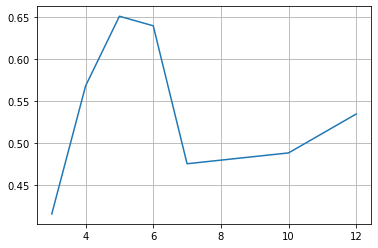

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
f,ax = plt.subplots()

pd.Series(v_coh, index=[len(topic) for topic in l_topics]).plot(ax=ax)
ax.grid()
#ax.set_ylim(0.2,0.7)

### LDA sur l'ensemble des donnée

In [20]:
importlib.reload(td)

<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [21]:
# Plusieurs essais random me montrent que sur la question sélectionnée UXVlc3Rpb246MTQ3
# le premier maximum de la coherence se trouve très souvent entre 5 et 6. 

n_topics = 5

In [22]:
topic_detector = td.GDebatTopicDetection(gd_prep, n_topics, verbose=1)

In [23]:
topic_detector.compute_topic_detection(data_bow=gd_prep.answ_bow, LDAVis=True)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100, perplexity: 710.8416
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100, perplexity: 638.2131
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100, perplexity: 623.1029
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100, perplexity: 617.8888
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 616.2495
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100, perplexity: 615.4767
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100, perplexi

In [24]:
for topic in topic_detector.get_topics_by_relevance(lambd=1):
    print(topic)

['chaleur', 'hiver', 'été', 'chaud', 'saison', 'période', 'neige', 'canicule', 'année']
['climatique', 'température', 'inondation', 'sécheresse', 'tempête', 'dérèglement', 'canicule', 'violent', 'saison']
['climatique', 'vie', 'changement', 'quotidien', 'enfant', 'impact', 'monde', 'avenir', 'consommation']
['pollution', 'air', 'ville', 'santé', 'allergie', 'problème', 'qualité', 'respiratoire', 'pic']
['disparition', 'eau', 'insecte', 'oiseau', 'espèce', 'animal', 'biodiversité', 'jardin', 'abeille']


### Interprétation et résumé

In [25]:
import grand_debat.text_summarization as ts
importlib.reload(ts)

<module 'grand_debat.text_summarization' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/text_summarization.py'>

In [26]:
titles = ts.create_titles(answers, topic_detector)

  0%|          | 0/92795 [00:00<?, ?it/s]

Sentence segmentation


  0%|          | 0/31176 [00:00<?, ?it/s]

Data preparation


100%|██████████| 31176/31176 [00:37<00:00, 831.38it/s]


LDA transformation


In [27]:
titles

['Plus de réelle saison : trop de fortes chaleurs en été et pas assez de périodes très froides en hiver',
 'Les saisons se suivent et ne se ressemblent pas, avec de plus en plus de dérèglements : canicule, sécheresse, tempêtes, inondations, températures anormales pour la saison',
 " Ma vie quotidienne est négativement touchée par le changement climatique et  par l'atmosphère de fin du monde que cette préoccupation planétaire instille dans nos cerveaux.",
 "Pollution beaucoup plus systématique qu'avant dans les villes, très mauvaise qualité de l'air, allergies, difficultés respiratoires à l'extérieur parfois.",
 ' La disparition d’espèces ( plantes , insectes, poissons , animaux terrestres , oiseaux , abeilles , etc ).']

J'interprête "à la main" chacun des thèmes comme cela :

In [28]:
topic_names = ["Biodiversité", "Pollution de l'air / santé", "Événements extrêmes", 
               "Réchauffement / saisons déréglées", 
               "Inquiétude avenir / impact sur nos dépenses" ]

In [29]:
import matplotlib.pyplot as plt
topics_pct = pd.Series(index=topic_names, 
                       data=(tf_lda.transform(tf_bow.transform(answ_lems)) >0.2).mean(axis=0)*100)

f,ax = plt.subplots()
topics_pct.sort_values().plot(kind="barh")
ax.grid()
ax.set_xlabel("%")
ax.set_title("Pourcentage des réponses\nmentionnant les thèmes suivants")

NameError: name 'tf_lda' is not defined

In [ ]:
# topics OpinionWay 
# https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf 
topics_ow = pd.Series(
    {"Les épisodes de chaleur, les sécheresses": 24.6,
    "Des événements climatiques plus fréquents": 16.5,
    "L'impact lié à la qualité de l'air": 12.4,
    "Autres impacts liés à la pollution": 12.2,
    "L'impact lié à l'eau : pollution, inondations, consommation": 9.3,
    "Les conséquences sur la santé": 11.9,
     "L'impact lié à la faune, la flore, la biodiversité": 8.4,
     "Autres éléments": 3.2,
     "Autres mentions concernant l'environnement": 2.4,
     "L'impact lié au littoral et à la mer": 1.4,
     "L'impact lié aux dépenses, prix, taxes": 1.3,
     "Trop de déchets, le problème de la gestion des déchets": 1.3,
     "L'impact lié à l'agriculture": 1.2,
     "L'impact lié aux transports": 1.1,
     "L'immigration de réfugiés climatiques": 0.6
    }
)

f,ax = plt.subplots()
topics_ow.sort_values().plot(kind="barh",ax=ax)
ax.grid()



<h2>Résumé de chaque thème</h2>
-  Résumer un grand thème en utilisant TextRank, technique de résumé extractive
-  Spécifier le nombre de phrases que l'on souhaite pour former le résumé dans la variable `sn`
-  Les résultats se situent dans le fichier demo.docx

In [ ]:
from grand_debat.text_summarization import prepare_data, apply_page_rank_algorithm, create_titles
from grand_debat.vectorization import sentence_to_vec
from grand_debat.clusterisation import apply_clusterisation

In [ ]:
#import nltk
#nltk.download('punkt')

Transformer le document texte en un ensemble de phrases dont la typographie est standardisée

In [ ]:
clean_sentences = prepare_data(data_theme_response_dict, selected_question)

Récupérer la phrase la plus caractéristique de chaque thème

In [ ]:
sentences_mixture_topics, title_sentences, titles = create_titles(clean_sentences, tf_bow, tf_lda)

Associer à chaque phrase du corpus son thème (issu de **LDA**) le plus carctéristique

In [ ]:
sentences_paragraph = apply_clusterisation(sentences_mixture_topics)

Représenter chaque phrase sous la forme d'un vecteur dense. Ces vecteurs sont obtenus à partir d'embeddings entraînés à partir de l'ensemble des contributions au Grand Débat

In [ ]:
sentence_vectors, word_embeddings = sentence_to_vec(clean_sentences, file_model='data/word2vec.10k.100d.txt')

On applique alors l'algorithme **TextRank** à l'ensemble des phrases d'un thème pour en extraire les phrases carctéristiques

In [ ]:
# Indiquer le nombre de phrases qui formeront le résumé
sn = 10
apply_page_rank_algorithm(clean_sentences, sentences_paragraph, word_embeddings, sn)